### Caso Práctico: Support Vector Machine (SVM)
Conjunto de datos: Detección de SPAM

### Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [ ]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

## Funciones auxiliares

In [ ]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    """
    Divide un DataFrame en tres conjuntos: entrenamiento, validación y prueba.

    Parámetros:
    - df: DataFrame que se desea dividir.
    - rstate: Semilla para la reproducibilidad de la aleatoriedad (valor por defecto: 42).
    - shuffle: Indica si se deben mezclar los datos antes de dividirlos (True por defecto).
    - stratify: Columna para realizar la estratificación, si es aplicable (None por defecto).

    Retorna:
    - train_set: Conjunto de entrenamiento.
    - val_set: Conjunto de validación.
    - test_set: Conjunto de prueba.
    """

    # Si se especifica estratificación, define la columna de referencia; si no, la establece en None.
    strat = df[stratify] if stratify else None

    # Divide el DataFrame original en conjunto de entrenamiento (60%) y conjunto temporal (40%)
    # Usa la semilla especificada para mantener la consistencia en la división.
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat
    )

    # Si la estratificación está habilitada, usa la columna correspondiente del conjunto temporal.
    strat = test_set[stratify] if stratify else None

    # Divide el conjunto temporal en validación (50% de temporal → 20% del total original)
    # y prueba (50% de temporal → 20% del total original).
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat
    )

    # Retorna las tres divisiones: entrenamiento, validación y prueba.
    return (train_set, val_set, test_set)


In [ ]:
# Representación gráfica del límite de decisión
# Función para graficar el límite de decisión de un clasificador SVM
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    """
    Grafica el límite de decisión, los márgenes y los vectores de soporte de un SVM.

    Parámetros:
    - svm_clf: Modelo SVM entrenado.
    - xmin: Valor mínimo del eje x para la visualización.
    - xmax: Valor máximo del eje x para la visualización.
    """

    # Coeficientes del hiperplano (w0, w1) y término de sesgo (b)
    w = svm_clf.coef_[0]          # Vector de pesos (w0, w1)
    b = svm_clf.intercept_[0]     # Término independiente (bias)

    # Calcula la recta del límite de decisión:
    # En el hiperplano: w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)         # Genera 200 puntos entre xmin y xmax
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]  # Ecuación del límite de decisión

    # Calcula los márgenes (paralelos a la frontera de decisión)
    margin = 1 / w[1]                        # Margen = 1 / norma del vector normal (w1)
    gutter_up = decision_boundary + margin   # Márgen superior
    gutter_down = decision_boundary - margin # Márgen inferior

    # Grafica los vectores de soporte
    svs = svm_clf.support_vectors_           # Obtiene los vectores de soporte
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')  # Vectores resaltados

    # Grafica la línea de decisión y los márgenes
    plt.plot(x0, decision_boundary, "k-", linewidth=2, label="Límite de decisión")  # Frontera
    plt.plot(x0, gutter_up, "k--", linewidth=2, label="Margen superior")           # Margen sup.
    plt.plot(x0, gutter_down, "k--", linewidth=2, label="Margen inferior")         # Margen inf.
    plt.legend()


## 1. Lectura del conjunto de datos

In [ ]:
df = pd.read_csv("/content/sample_data/Spam.csv")

## 2. Visualización preliminar de la información

In [ ]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


## Descripción de los campos

| Campo en inglés                | Traducción en español                    |
|--------------------------------|-----------------------------------------|
| Querylength                   | Longitud de la consulta                |
| domain_token_count            | Número de tokens en el dominio         |
| path_token_count              | Número de tokens en la ruta            |
| avgdomaintokenlen             | Longitud promedio de tokens en dominio |
| longdomaintokenlen            | Longitud del token más largo en dominio |
| avgpathtokenlen               | Longitud promedio de tokens en ruta    |
| tld                           | Dominio de nivel superior (TLD)        |
| charcompvowels                | Complejidad de caracteres (vocales)    |
| charcompace                   | Complejidad de caracteres (espacios)   |
| ldl_url                       | Longitud de URL normalizada            |
| SymbolCount_FileName          | Recuento de símbolos en el nombre de archivo |
| SymbolCount_Extension         | Recuento de símbolos en la extensión   |
| SymbolCount_Afterpath         | Recuento de símbolos después de la ruta |
| Entropy_URL                   | Entropía de la URL                     |
| Entropy_Domain                | Entropía del dominio                   |
| Entropy_DirectoryName         | Entropía del nombre del directorio     |
| Entropy_Filename              | Entropía del nombre del archivo        |
| Entropy_Extension             | Entropía de la extensión               |
| Entropy_Afterpath             | Entropía después de la ruta            |
| URL_Type_obf_Type             | Tipo de ofuscación de la URL           |


In [ ]:
df.describe()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
count,14479.000000,14479.000000,14479.000000,14479.000000,14479.000000,14467.000000,14479.000000,14479.000000,14479.000000,14479.000000,...,14479.000000,14479.000000,14479.000000,14479.000000,14479.000000,14479.000000,12600.000000,14313.000000,14476.000000,14476.000000
mean,36.960909,2.757373,10.154914,4.772610,8.213205,4.698062,2.757373,18.186891,13.129291,5.836453,...,2.031079,3.200981,2.305408,1.404241,0.715408,0.861473,0.679250,0.674436,0.445106,-0.199185
std,145.692631,0.915276,4.350838,1.534679,3.381107,2.164559,0.915276,17.417598,14.920422,20.412477,...,2.803039,4.147484,3.818126,3.595413,0.049224,0.062471,0.459000,0.434618,0.541818,0.895735
min,0.000000,2.000000,0.000000,2.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.499318,0.685962,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,2.000000,7.000000,3.666667,6.000000,3.600000,2.000000,10.000000,6.000000,0.000000,...,1.000000,0.000000,0.000000,-1.000000,0.686835,0.808833,0.741775,0.697753,0.000000,-1.000000
50%,0.000000,3.000000,10.000000,4.500000,8.000000,4.250000,3.000000,15.000000,10.000000,0.000000,...,2.000000,1.000000,0.000000,-1.000000,0.721860,0.863489,0.802150,0.763483,0.709187,-1.000000
75%,18.000000,3.000000,13.000000,6.000000,10.000000,5.142857,3.000000,21.000000,15.000000,3.000000,...,3.000000,5.000000,4.000000,3.000000,0.746377,0.897617,0.851410,0.839698,0.851814,0.775559
max,1385.000000,5.000000,68.000000,13.000000,23.000000,65.000000,5.000000,193.000000,142.000000,207.000000,...,19.000000,31.000000,30.000000,29.000000,0.895403,1.000000,0.962479,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14479 entries, 0 to 14478
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      14479 non-null  int64  
 1   domain_token_count               14479 non-null  int64  
 2   path_token_count                 14479 non-null  int64  
 3   avgdomaintokenlen                14479 non-null  float64
 4   longdomaintokenlen               14479 non-null  int64  
 5   avgpathtokenlen                  14467 non-null  float64
 6   tld                              14479 non-null  int64  
 7   charcompvowels                   14479 non-null  int64  
 8   charcompace                      14479 non-null  int64  
 9   ldl_url                          14479 non-null  int64  
 10  ldl_domain                       14479 non-null  int64  
 11  ldl_path                         14479 non-null  int64  
 12  ldl_filename      

¿Cuántos ejemplos esisten para 'URL_Type_obf_Type'?

In [ ]:
df["URL_Type_obf_Type"].value_counts() 

,count
URL_Type_obf_Type,
benign,7781
spam,6698


Comprobación de si existen valores nulos

In [ ]:
is_null = df.isna().any()
is_null[is_null]

,0
avgpathtokenlen,True
NumberRate_Extension,True
NumberRate_AfterPath,True
Entropy_DirectoryName,True
Entropy_Filename,True
Entropy_Extension,True
Entropy_Afterpath,True


Comprobación de la existencia de valores infinitos

In [ ]:
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

,0


Sugerencias de campos para comparar


1. Longitud y estructura de la URL

  * Querylength (Longitud de la consulta)

  * ldl_url (Longitud de URL normalizada)

2. Características del dominio y ruta

  * domain_token_count (Número de tokens en el dominio)

  * path_token_count (Número de tokens en la ruta)

  * avgdomaintokenlen (Longitud promedio de tokens en el dominio)

  * avgpathtokenlen (Longitud promedio de tokens en la ruta)

  * longdomaintokenlen (Longitud del token más largo en el dominio)

3. Complejidad de caracteres

  * charcompvowels (Complejidad de caracteres en vocales)

  * charcompace (Complejidad de caracteres en espacios)

  4. Símbolos en el nombre de archivos y extensiones

  * SymbolCount_FileName (Recuento de símbolos en el nombre de archivo)

  * SymbolCount_Extension (Recuento de símbolos en la extensión)

  * SymbolCount_Afterpath (Recuento de símbolos después de la ruta)

5. Entropía (Medida de Aleatoriedad)

  * Entropy_URL (Entropía de la URL)

  * Entropy_Domain (Entropía del dominio)

  * Entropy_DirectoryName (Entropía del nombre del directorio)

  * Entropy_Filename (Entropía del nombre del archivo)

  * Entropy_Extension (Entropía de la extensión)

  * Entropy_Afterpath (Entropía después de la ruta)



## Representación gráfica
Generamos un diagrama de dispersión (scatter plot) que compara dos variables del dataset para dos categorías diferentes:

domainUrlRatio → Proporción del dominio en la URL.
domainlength → Longitud del dominio.

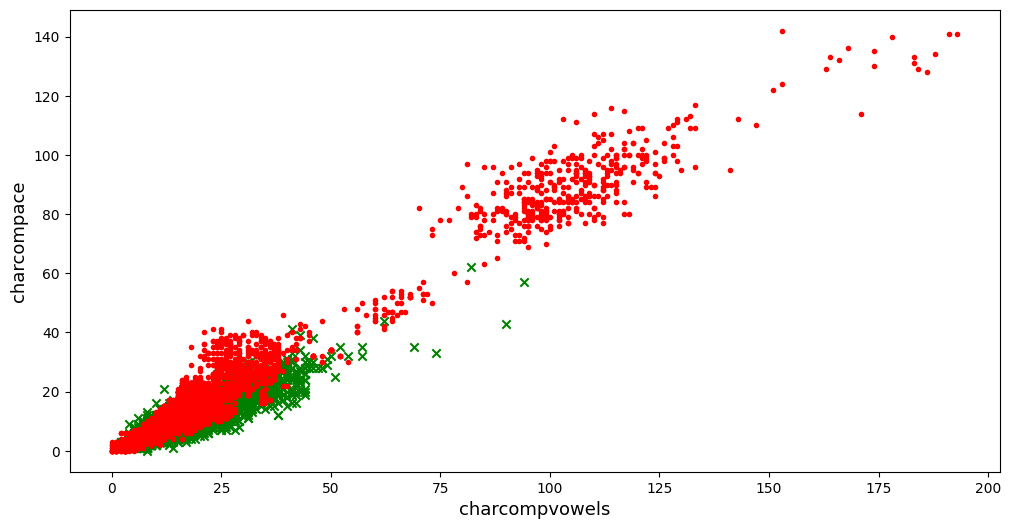

In [ ]:
# Representación gráfica de dos características
plt.figure(figsize=(12, 6))

plt.scatter(
    df["charcompvowels"][df['URL_Type_obf_Type'] == "benign"],    # Eje X: charcompvowels (solo para benign)
    df["charcompace"][df['URL_Type_obf_Type'] == "benign"],      # Eje Y: charcompace (solo para benign)
    c="g",                     # Color verde para los casos benignos
    marker="x"                  # Marcador tipo "x" para benignos
)
plt.scatter(
    df["charcompvowels"][df['URL_Type_obf_Type'] == "spam"],  # Eje X: charcompvowels (solo para spam)
    df["charcompace"][df['URL_Type_obf_Type'] == "spam"],    # Eje Y: charcompace (solo para spam)
    c="r",                     # Color rojo para los casos de phishing
    marker="."                  # Marcador tipo punto para phishing
)
plt.xlabel("charcompvowels", fontsize=13)
plt.ylabel("charcompace", fontsize=13)
plt.show()

## 3. División del conjunto de datos

In [ ]:
# División del conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [ ]:
# Separar las características (X) y la variable objetivo (y) para el conjunto de entrenamiento
X_train = train_set.drop("URL_Type_obf_Type", axis=1)  # Elimina la columna objetivo del conjunto de entrenamiento
y_train = train_set["URL_Type_obf_Type"].copy()         # Copia la columna objetivo como y_train

# Separar las características y la variable objetivo para el conjunto de validación
X_val = val_set.drop("URL_Type_obf_Type", axis=1)      # Elimina la columna objetivo del conjunto de validación
y_val = val_set["URL_Type_obf_Type"].copy()             # Copia la columna objetivo como y_val

# Separar las características y la variable objetivo para el conjunto de prueba
X_test = test_set.drop("URL_Type_obf_Type", axis=1)    # Elimina la columna objetivo del conjunto de prueba
y_test = test_set["URL_Type_obf_Type"].copy()           # Copia la columna objetivo como y_test


## 4. Preparación del conjunto de datos

* Eliminamos el atributo que tiene valores infinitos
* No existen campos con datos infinitos

In [ ]:
# Rellenamos los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median") # Los valores NaN se sustituyen por la mediana de los datos del campo

In [ ]:
# Rellenamos los valores nulos
X_train_prep = imputer.fit_transform(X_train)  # Rellena los valores faltantes de X_train con la estrategia definida en el imputer

# Aplicar el imputador para manejar los valores faltantes en el conjunto de validación
X_val_prep = imputer.fit_transform(X_val)      # Rellena los valores faltantes de X_val con la estrategia definida en el imputer

# Aplicar el imputador para manejar los valores faltantes en el conjunto de prueba
X_test_prep = imputer.fit_transform(X_test)    # Rellena los valores faltantes de X_test con la estrategia definida en el imputer


In [ ]:
# Transformamos el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_prep, columns=X_train.columns, index=y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns=X_val.columns, index=y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns=X_test.columns, index=y_test.index)

In [ ]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
9681,35.0,3.0,15.0,4.333334,9.0,3.600000,3.0,23.0,22.0,7.0,...,1.0,11.0,10.0,3.0,0.700620,0.897617,0.871049,0.713663,0.718307,0.770361
400,0.0,2.0,19.0,5.500000,8.0,4.578947,2.0,31.0,19.0,1.0,...,-1.0,-1.0,-1.0,-1.0,0.645024,0.953510,-1.000000,-1.000000,-1.000000,-1.000000
13198,42.0,3.0,10.0,6.000000,14.0,3.666667,3.0,14.0,10.0,9.0,...,2.0,7.0,6.0,5.0,0.733139,0.765560,0.831955,0.776605,0.772978,0.767154
7105,0.0,2.0,10.0,9.500000,16.0,4.600000,2.0,15.0,11.0,0.0,...,-1.0,0.0,0.0,-1.0,0.701718,0.843707,0.803599,0.731680,0.000000,-1.000000
7991,265.0,3.0,6.0,4.333334,9.0,2.500000,3.0,30.0,27.0,38.0,...,1.0,3.0,2.0,1.0,0.676365,0.863489,0.827729,0.677423,0.674941,0.672047
7224,0.0,2.0,8.0,7.000000,11.0,4.000000,2.0,4.0,4.0,0.0,...,3.0,1.0,0.0,-1.0,0.742380,0.931745,0.783026,0.866748,1.000000,-1.000000
9522,52.0,3.0,12.0,6.666666,16.0,3.750000,3.0,21.0,20.0,12.0,...,1.0,8.0,7.0,6.0,0.743661,0.801139,0.879588,0.780641,0.788342,0.784840
1023,0.0,2.0,9.0,3.500000,4.0,4.888889,2.0,19.0,8.0,0.0,...,1.0,0.0,0.0,-1.0,0.716063,0.916667,0.898227,0.718840,0.000000,-1.000000
3298,0.0,3.0,14.0,4.000000,7.0,5.000000,3.0,27.0,17.0,0.0,...,-1.0,-1.0,-1.0,-1.0,0.678086,0.924957,-1.000000,-1.000000,-1.000000,-1.000000
9481,9.0,3.0,11.0,2.666667,4.0,11.333333,3.0,37.0,24.0,9.0,...,2.0,11.0,10.0,7.0,0.692647,0.879588,0.829302,0.717202,0.718251,0.699295


In [ ]:
# Comprobamos si hay valores nulos en el conjunto de datos de entrenamiento
is_null = X_train_prep.isna().any()
is_null[is_null]

,0


## 5. SMV: Kernel lineal

### 5.1 Conjunto de datos reducidos
**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Reducimos el conjunto de datos para representarlo gráficamente
# Seleccionar solo las columnas 'domainUrlRatio' y 'charcompace' del conjunto de entrenamiento y crear una copia
X_train_reduced = X_train_prep[["charcompvowels", "charcompace"]].copy()  # Selecciona las columnas relevantes de X_train_prep

# Seleccionar solo las columnas 'charcompvowels' y 'charcompace' del conjunto de validación y crear una copia
X_val_reduced = X_val_prep[["charcompvowels", "charcompace"]].copy()      # Selecciona las columnas relevantes de X_val_prep


In [ ]:
X_train_reduced #Mostrando datos de ejemplo

,charcompvowels,charcompace
9681,23.0,22.0
400,31.0,19.0
13198,14.0,10.0
7105,15.0,11.0
7991,30.0,27.0
...,...,...
5191,29.0,24.0
13418,11.0,9.0
5390,12.0,5.0
860,24.0,12.0


In [ ]:
from sklearn.svm import SVC

# SVM Large Margin Classification

# Crear el clasificador SVM con un kernel lineal y un valor de penalización C de 50
svm_clf = SVC(kernel="linear", C=50)  # 'kernel="linear"' especifica un SVM con kernel lineal, y 'C=50' ajusta la penalización (distancia de márgenes)

# Ajustar el modelo SVM usando el conjunto de entrenamiento reducido
svm_clf.fit(X_train_reduced, y_train)  # Entrenar el clasificador SVM con las características y etiquetas del conjunto de entrenamiento


SVC(C=50, kernel='linear')

In [ ]:
# Función para graficar el límite de decisión de un clasificador SVM
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    # Extraer los coeficientes (w) y el término de intercepto (b) del clasificador SVM
    w = svm_clf.coef_[0]  # Coeficientes del modelo SVM
    b = svm_clf.intercept_[0]  # Término de intercepto del modelo SVM

    # Generar un rango de valores para x0 entre xmin y xmax
    x0 = np.linspace(xmin, xmax, 200)  # 200 puntos entre xmin y xmax

    # Calcular la frontera de decisión (límite) en función de los coeficientes y el intercepto
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]  # Ecuación de la recta de decisión

    # Calcular los márgenes (gutter) superior e inferior
    margin = 1/w[1]  # Margen de separación entre las clases
    gutter_up = decision_boundary + margin  # Margen superior
    gutter_down = decision_boundary - margin  # Margen inferior

    # Obtener los vectores de soporte del modelo SVM
    svs = svm_clf.support_vectors_  # Los puntos de soporte

    # Graficar los vectores de soporte con un color rojo claro y tamaño grande
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')  # Vectores de soporte: son los datos que más se acercan a la frontera de decisión

    # Graficar la frontera de decisión en negro
    plt.plot(x0, decision_boundary, "k-", linewidth=2)  # Límite de decisión

    # Graficar los márgenes superior e inferior con líneas discontinuas
    plt.plot(x0, gutter_up, "k--", linewidth=2)  # Margen superior
    plt.plot(x0, gutter_down, "k--", linewidth=2)  # Margen inferior


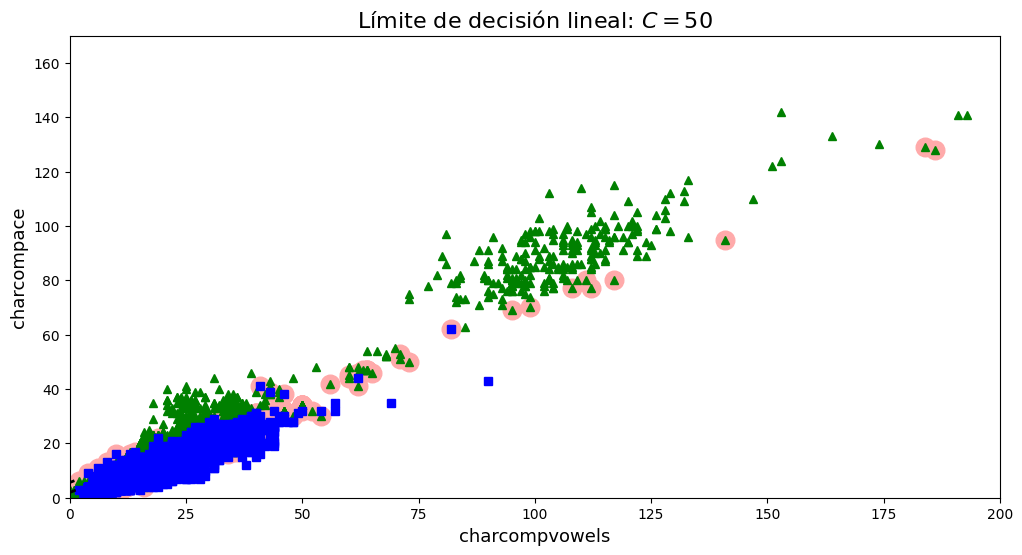

In [ ]:
plt.figure(figsize=(12, 6))  # Crea una nueva figura con un tamaño de 12x6 pulgadas
plt.plot(X_train_reduced.values[:, 0][y_train=="spam"], X_train_reduced.values[:, 1][y_train=="spam"], "g^")  # Dibuja los puntos de la clase "phishing" con triángulos verdes
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")  # Dibuja los puntos de la clase "benign" con cuadrados azules
plot_svc_decision_boundary(svm_clf, 0, 1)  # Llama a la función para trazar la frontera de decisión del SVM
plt.title("Límite de decisión lineal: $C = {}$".format(svm_clf.C), fontsize=16)  # Añade un título con el valor de C del SVM
plt.axis([0,200,0,170])  # Define los límites de los ejes X e Y
plt.xlabel("charcompvowels", fontsize=13)  # Etiqueta para el eje X
plt.ylabel("charcompace", fontsize=13)  # Etiqueta para el eje Y
plt.show()  # Muestra la gráfica

**Predicción con un conjunto de datos reducido**

In [ ]:
y_pred = svm_clf.predict(X_val_reduced) # Contiene datos que no fueron usados durante el entrenamiento

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='spam')) # Compara los nuevos datos contra los datos reales

F1 Score: 0.5114942528735632


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?             | ✅            |


## Escalado de datos para tratar de mejorar el resultado de la predicción
Para determinados kernels es muy importante escalar el conjunto de datos. En ese caso, para el kernel lineal, no es tan relevante, aunque es posible que proporciones mejores resultados.

In [ ]:
svm_clf_sc = Pipeline([
    ("scaler", RobustScaler()),  # 1. Aplica una escala robusta para manejar valores atípicos
    ("linear_svc", SVC(kernel="linear", C=50)),  # 2. Entrena un SVM con un kernel lineal y C=50
])

svm_clf_sc.fit(X_train_reduced, y_train)  # 3. Ajusta el pipeline con los datos de entrenamiento


Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [ ]:
y_pred = svm_clf_sc.predict(X_val_reduced) # Contiene datos que no fueron usados durante el entrenamiento

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='spam')) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.5114942528735632


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?             | ✅            |
| Reducido        | Lineal (escalado)                      | ?             | ✅            |

### 5.2 Conjunto de datos completo

A continuación se entrenará el modelo con todos los datos de entrada.

In [ ]:
# Entrenamiento con todo el conjunto de datos
from sklearn.svm import SVC

svm_clf = SVC(kernel="linear", C=1) # Se aplicará un Kernel lineal
svm_clf.fit(X_train_prep, y_train) # 'X_train_prep' contiene todos los datos de entrada

SVC(C=1, kernel='linear')

In [ ]:
y_pred = svm_clf.predict(X_val_prep) # Probando el modelo con datos distintos a los de entrenamiento

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val, pos_label='spam')) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.9970523212969786


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?             | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?             | ✅            |

## 6. SMV: Kernel no lineal

Se intentará mejorar la eficiencia del modelo utilizando ahora un Kernel no lineal

### 6.1. Polynomial Kernel (I)
**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Para representar el límite de decisión tenemos que pasar la variable objetivo a numérica
y_train_num = y_train.factorize()[0] # Transforma las etiquetas de texto ('benign' y 'spam') en valores numéricos (0 y 1)
y_val_num = y_val.factorize()[0] # Aplica el mismo proceso a los datos de validación

In [ ]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),  # Genera características polinomiales de grado 3 para mejorar la separación de datos no lineales
    ("scaler", StandardScaler()),  # Normaliza los datos para mejorar la estabilidad numérica del modelo
    ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000, dual=True))  # Clasificador SVM con kernel lineal y margen más flexible (C=20)
])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)  # Entrena el modelo SVM polinómico con los datos transformados


#Aunque el modelo se entrena utilizando una función lineal como 'LinearSVC' el tratamiento de sus datos es polinomial

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, dual=True, loss='hinge', max_iter=100000,
                           random_state=42))])

**Representación del límite de decisión**

In [ ]:
def plot_dataset(X, y):
    # Dibuja los puntos del conjunto de datos
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g.")  # Muestra los puntos de la clase 1 (phishing) en verde
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "b.")  # Muestra los puntos de la clase 0 (benign) en azul

Text(0, 0.5, 'charcompace')

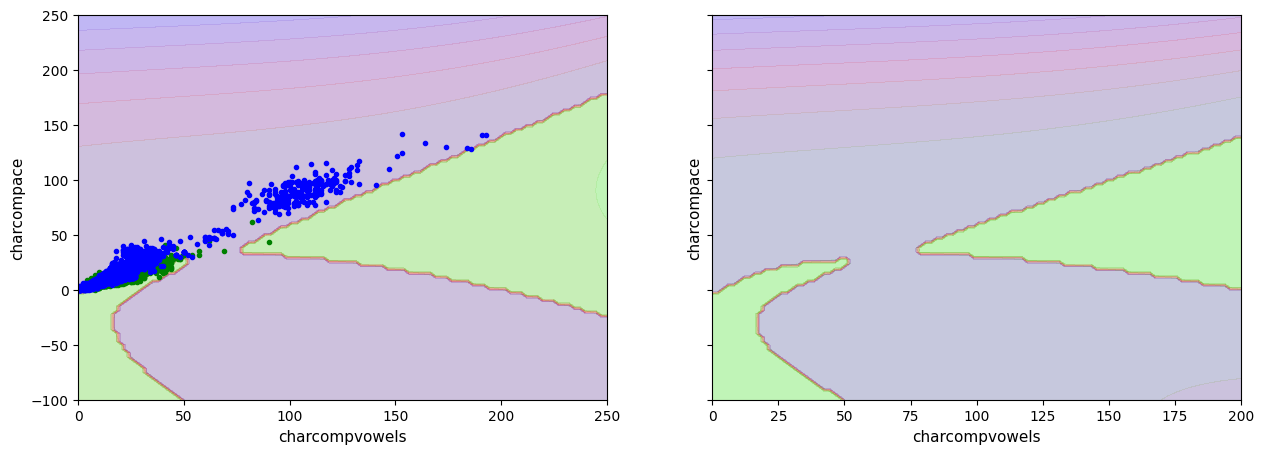

In [ ]:
def plot_predictions(clf, axes):
    # Genera una malla de puntos para graficar la frontera de decisión
    x0s = np.linspace(axes[0], axes[1], 100)  # Valores en el eje X
    x1s = np.linspace(axes[2], axes[3], 100)  # Valores en el eje Y
    x0, x1 = np.meshgrid(x0s, x1s)  # Crea una malla 2D con todos los puntos de la región
    X = np.c_[x0.ravel(), x1.ravel()]  # Convierte la malla en una lista de pares (x0, x1)

    y_pred = clf.predict(X).reshape(x0.shape)  # Predice la clase de cada punto en la malla
    y_decision = clf.decision_function(X).reshape(x0.shape)  # Calcula la distancia de cada punto al hiperplano

    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # Dibuja el mapa de clasificación
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)  # Dibuja las zonas de decisión

# Crea dos gráficos lado a lado
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)  # Dos gráficos en la misma fila con ejes Y compartidos

plt.sca(axes[0])  # Activa el primer gráfico
plot_dataset(X_train_reduced.values, y_train_num)  # Dibuja los datos reales
plot_predictions(polynomial_svm_clf, [0,250, -100, 250])  # Dibuja la frontera de decisión del modelo
plt.xlabel("charcompvowels", fontsize=11)  # Etiqueta del eje X
plt.ylabel("charcompace", fontsize=11)  # Etiqueta del eje Y

plt.sca(axes[1])  # Activa el segundo gráfico
plot_predictions(polynomial_svm_clf, [0, 200, -100, 250])  # Dibuja solo la frontera de decisión del modelo
plt.xlabel("charcompvowels", fontsize=11)  # Etiqueta del eje X
plt.ylabel("charcompace", fontsize=11)  # Etiqueta del eje Y


**Predicción con el conjunto de datos reducido**

In [ ]:
y_pred = polynomial_svm_clf.predict(X_val_reduced) # Probando el modelo con datos distintos a los de entrenamiento

In [ ]:
print("F1 Score:", f1_score(y_pred, y_val_num))  # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.36810187992722865


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?            | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?             | ✅            |
| Reducido        | Lineal con características polinomiales | ?            | ❌            |

### 6.2. Polynomial Kernel (II)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [ ]:
# Crea un clasificador SVM con un kernel polinómico de grado 3
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)

# Entrena el clasificador con los datos de entrenamiento reducidos
svm_clf.fit(X_train_reduced, y_train_num)

SVC(C=20, coef0=10, kernel='poly')

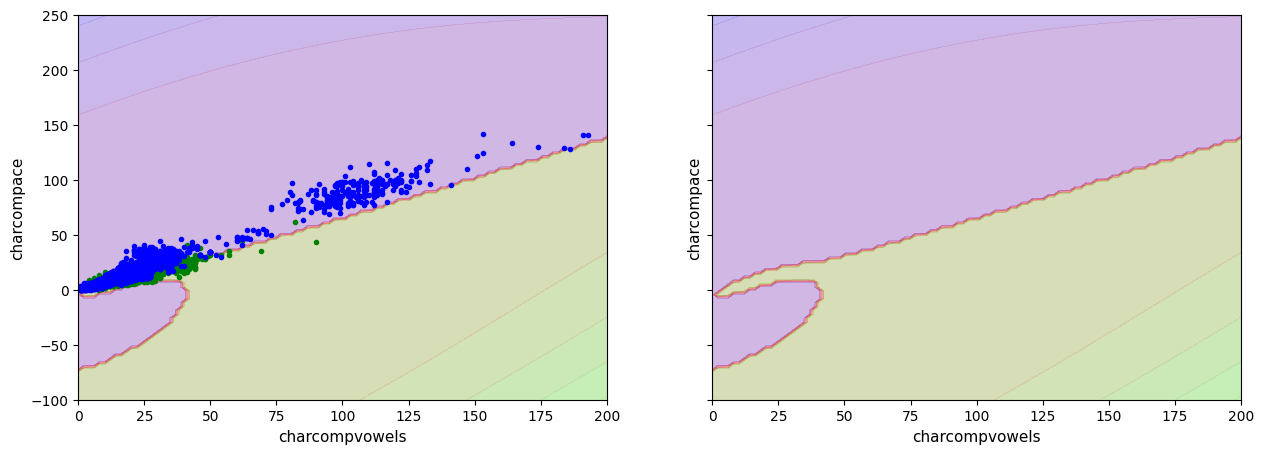

In [ ]:
# Crea una figura con dos gráficos en una misma fila
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)  # Comparte el eje Y entre ambos gráficos

# Primer gráfico
plt.sca(axes[0])  # Selecciona el primer gráfico
plot_dataset(X_train_reduced.values, y_train_num)  # Dibuja los datos reales
plot_predictions(svm_clf, [0,200, -100, 250])  # Dibuja la frontera de decisión del modelo
plt.xlabel("charcompvowels", fontsize=11)  # Etiqueta del eje X
plt.ylabel("charcompace", fontsize=11)  # Etiqueta del eje Y

# Segundo gráfico
plt.sca(axes[1])  # Selecciona el segundo gráfico
plot_predictions(svm_clf, [0,200, -100, 250])  # Solo la frontera de decisión del modelo
plt.xlabel("charcompvowels", fontsize=11)  # Etiqueta del eje X
plt.ylabel("charcompace", fontsize=11)  # Etiqueta del eje Y

plt.show()  # Muestra los gráficos

**Predicción con un conjunto de datos reducido**

In [ ]:
y_pred = svm_clf.predict(X_val_reduced) # Probando el modelo con datos distintos a los de entrenamiento
print("F1 Score:", f1_score(y_pred, y_val_num)) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.37697584252907845


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?             | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?             | ✅            |
| Reducido        | Lineal con características polinomiales | ?             | ❌            |
| Reducido        | Polinomial                              | ?             | ❌            |

**Predicción con el conjunto de datos completo**

In [ ]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=40) # Se entrena el modelo polinomial con la totalidad de campos
svm_clf.fit(X_train_prep, y_train_num)

SVC(C=40, coef0=10, kernel='poly')

In [ ]:
y_pred = svm_clf.predict(X_val_prep)
print("F1 Score:", f1_score(y_pred, y_val_num)) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.0013831258644536654


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?           | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?             | ✅            |
| Reducido        | Lineal con características polinomiales | ?             | ❌            |
| Reducido        | Polinomial                              | ?             | ❌            |
| Completo        | Polinomial                              | ?            | ❌            |

### 6.2. Gaussian Kernel

In [ ]:
# Crea un pipeline que incluye un escalador robusto y un clasificador SVM con kernel RBF
rbf_kernel_svm_clf = Pipeline([
    ("scaler", RobustScaler()),  # Escala los datos usando RobustScaler para manejar valores atípicos
    ("svm_clf", SVC(kernel="rbf", gamma=0.5, C=1000))  # Modelo SVM con kernel RBF (Radial Basis Function) el cual es un kernel gausiano
])

# Entrena el modelo SVM con los datos de entrenamiento reducidos
rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.5))])

**Representación del límite de decisión**

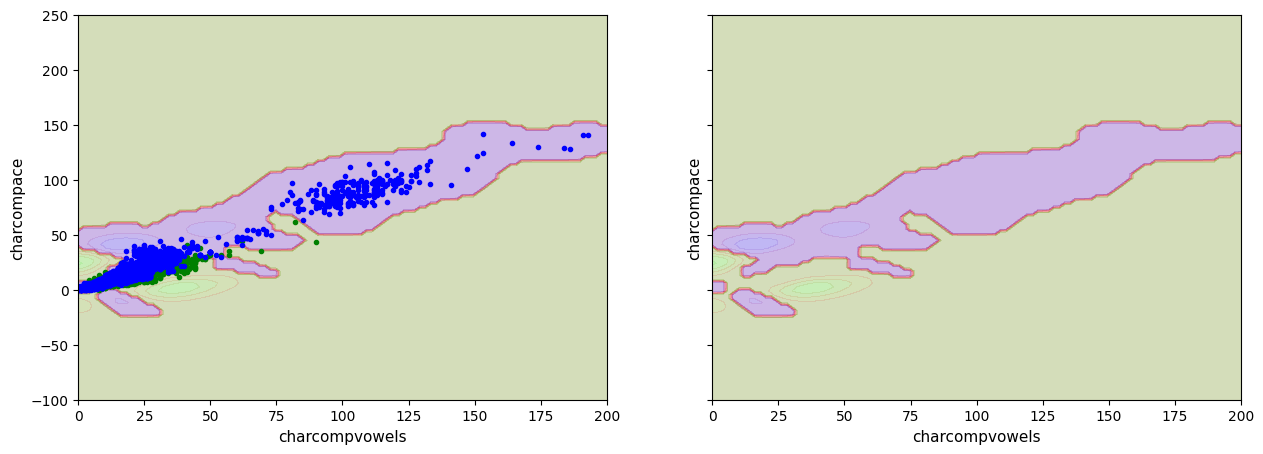

In [ ]:
# Crea una figura con dos gráficos en una fila (dos columnas) y un tamaño de 15x5 pulgadas
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

# Selecciona el primer gráfico (izquierda)
plt.sca(axes[0])
# Dibuja los puntos del conjunto de entrenamiento reducido
plot_dataset(X_train_reduced.values, y_train_num)
# Dibuja la frontera de decisión del modelo SVM con kernel RBF
plot_predictions(rbf_kernel_svm_clf, [0,200, -100, 250])
# Etiqueta del eje X
plt.xlabel("charcompvowels", fontsize=11)
# Etiqueta del eje Y
plt.ylabel("charcompace", fontsize=11)

# Selecciona el segundo gráfico (derecha)
plt.sca(axes[1])
# Dibuja la frontera de decisión sin los puntos de entrenamiento
plot_predictions(rbf_kernel_svm_clf, [0,200, -100, 250])
# Etiqueta del eje X
plt.xlabel("charcompvowels", fontsize=11)
# Etiqueta del eje Y
plt.ylabel("charcompace", fontsize=11)

# Muestra la figura con ambos gráficos
plt.show()


**Predicción con un conjunto de datos reducido**

In [ ]:
#y_pred = svm_clf.predict(X_val_reduced) # Probando el modelo con datos distintos a los de entrenamiento
#print("F1 Score:", f1_score(y_pred, y_val_num)) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

y_pred = rbf_kernel_svm_clf.predict(X_val_reduced) # Se usa el rbf_kernel_svm_clf para pocos datos
print("F1 Score:", f1_score(y_pred, y_val_num)) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.3871527777777778


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?            | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?             | ✅            |
| Reducido        | Lineal con características polinomiales | ?             | ❌            |
| Reducido        | Polinomial                              | ?            | ❌            |
| Completo        | Polinomial                              | ?             | ❌            |
| Reducido        | Gausiano (RBF)                          | ?             | ❌            |

**Predicción con un conjunto de datos completo**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", RobustScaler()),  # Normaliza los datos usando RobustScaler para reducir la influencia de valores atípicos
    ("svm_clf", SVC(kernel="rbf", gamma=0.05, C=1000))  # Modelo SVM con kernel RBF, gamma=0.05 y C=1000
])

# Entrena el modelo SVM con los datos preprocesados (normalizados) y las etiquetas numéricas
rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)


Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.05))])

In [ ]:
y_pred = rbf_kernel_svm_clf.predict(X_val_prep) # Probando el modelo con datos distintos a los de entrenamiento
print("F1 Score:", f1_score(y_pred, y_val_num)) # Compara los nuevos datos contra los datos reales y arroja un F1 Score

F1 Score: 0.017158544955387784


**Análisis de resultados al momento**

| Conjunto de datos | Kernel                                   | F1 Score           | Mejor F1 Score |
|------------------|----------------------------------------|--------------------|---------------|
| Reducido        | Lineal                                  | ?            | ❌            |
| Reducido        | Lineal (escalado)                      | ?             | ❌            |
| Completo          | Lineal                                  | ?           | ✅            |
| Reducido        | Lineal con características polinomiales | ?            | ❌            |
| Reducido        | Polinomial                              | ?             | ❌            |
| Completo        | Polinomial                              | ?             | ❌            |
| Reducido        | Gausiano (RBF)                          | ?             | ❌            |
| Completo        | Gausiano (RBF)                          | ?             | ❌            |